In [1]:
import os
from dotenv import load_dotenv
from typing import List, Union

load_dotenv()
api_claude=os.getenv("api_claude")

def completions_create(client, messages: list, model: str) -> str:
    response = client.invoke(messages)
    return str(response.content)

def build_prompt_structure(prompt: str, role: str, tag: str = "") -> dict:
    if tag:
        prompt = f"<{tag}>{prompt}</{tag}>"
    return {"role": role, "content": prompt}

def update_chat_history(history: list, msg: str, role: str):
    history.append(build_prompt_structure(prompt=msg, role=role))

class ChatHistory(list):
    def __init__(self, messages: Union[List,None] = None, total_length: int = -1):
        if messages is None:
            messages = []

        super().__init__(messages)
        self.total_length = total_length

    def append(self, msg: str):
        if len(self) == self.total_length:
            self.pop(0)
        super().append(msg)


import re
from dataclasses import dataclass


@dataclass
class TagContentResult:
    content: List[str]
    found: bool


def extract_tag_content(text: str, tag: str) -> TagContentResult:
    tag_pattern = rf"<{tag}>(.*?)</{tag}>"
    
    matched_contents = re.findall(tag_pattern, text, re.DOTALL)
    
    return TagContentResult(
        content=[content.strip() for content in matched_contents],
        found=bool(matched_contents),
    )


In [2]:
import json
from typing import Callable

def get_fn_signature(fn: Callable) -> dict:
    fn_signature: dict = {
        "name": fn.__name__,
        "description": fn.__doc__,
        "parameters": {"properties": {}},
    }
    schema = {
        k: {"type": v.__name__} for k, v in fn.__annotations__.items() if k != "return"
    }
    fn_signature["parameters"]["properties"] = schema
    return fn_signature

def validate_arguments(tool_call: dict, tool_signature: dict) -> dict:
    return tool_call

class Tool:
    def __init__(self, name: str, fn: Callable, fn_signature: str):
        self.name = name
        self.fn = fn
        self.fn_signature = fn_signature

    def __str__(self):
        return self.fn_signature

    def run(self, **kwargs):
        return self.fn(**kwargs)

def tool(fn: Callable):
    def wrapper():
        fn_signature = get_fn_signature(fn)
        return Tool(
            name=fn_signature.get("name"), fn=fn, fn_signature=json.dumps(fn_signature)
        )

    return wrapper()

In [3]:
from typing import List, Union
from langchain_anthropic import ChatAnthropic

BASE_SYSTEM_PROMPT = ""

REACT_SYSTEM_PROMPT = """
Para operar, ejecute un bucle con los siguientes pasos: pensamiento, acción y observación.
Se le proporcionan firmas de funciones dentro de las etiquetas XML <tools></tools>.
Puede llamar a una o más funciones para ayudar con la consulta del usuario. No haga suposiciones sobre qué valores debe incluir en las funciones. 
Preste especial atención a las propiedades "tipos". 
Debe utilizar esos tipos como en un diccionario de Python.

Para cada llamada de función, devuelva un objeto json con el nombre de la función y los argumentos dentro de las etiquetas XML <tool_call></tool_call> de la siguiente manera:

<tool_call>
{"name": <function-name>,"arguments": <args-dict>, "id": <monotonically-increasing-id>}
</tool_call>

Estas son las herramientas/acciones disponibles:

<tools>
%s
</tools>

Sesión de ejemplo:

<question>¿Cuál es la temperatura actual en Madrid?</question>
<thought>Necesito obtener el clima actual en Madrid</thought>
<tool_call>{"name": "get_current_weather","arguments": {"location": "Madrid", "unit": "celsius"}, "id": 0}</tool_call>

Se le llamará nuevamente con esto:

<observation>{0: {"temperature": 25, "unit": "celsius"}}</observation>

Luego, imprime:

<response>La temperatura actual en Madrid es de 25 grados Celsius</response>

Restricciones adicionales:

- Si el usuario te pregunta algo que no esté relacionado con ninguna de las herramientas anteriores, responde libremente encerrando tu respuesta entre las etiquetas <response></response>.
"""

class ReactAgent:
    def __init__(
        self,
        tools: Union[Tool,List[Tool]],
        model: str = "claude-3-5-sonnet-20240620",
        system_prompt: str = BASE_SYSTEM_PROMPT,
    ) -> None:
        self.client = ChatAnthropic(model=model,api_key=api_claude)
        self.model = model
        self.system_prompt = system_prompt
        self.tools = tools if isinstance(tools, list) else [tools]
        self.tools_dict = {tool.name: tool for tool in self.tools}

    def add_tool_signatures(self) -> str:
        return "".join([tool.fn_signature for tool in self.tools])

    def process_tool_calls(self, tool_calls_content: list) -> dict:
        observations = {}
        for tool_call_str in tool_calls_content:
            tool_call = json.loads(tool_call_str)
            tool_name = tool_call["name"]
            tool = self.tools_dict[tool_name]

            print(Fore.GREEN + f"\nUsing Tool: {tool_name}")

            validated_tool_call = validate_arguments(
                tool_call, json.loads(tool.fn_signature)
            )
            print(Fore.GREEN + f"\nTool call dict: \n{validated_tool_call}")

            result = tool.run(**validated_tool_call["arguments"])
            print(Fore.GREEN + f"\nTool result: \n{result}")

            observations[validated_tool_call["id"]] = result

        return observations
    
    def run(
        self,
        user_msg: str,
        max_rounds: int = 10,
    ) -> str:
        user_prompt = build_prompt_structure(
            prompt=user_msg, role="user", tag="question"
        )
        if self.tools:
            self.system_prompt += (
                "\n" + REACT_SYSTEM_PROMPT % self.add_tool_signatures()
            )

        chat_history = ChatHistory(
            [
                build_prompt_structure(
                    prompt=self.system_prompt,
                    role="system",
                ),
                user_prompt,
            ]
        )

        if self.tools:
            # Run the ReAct loop for max_rounds
            for _ in range(max_rounds):

                completion = completions_create(self.client, chat_history, self.model)

                response = extract_tag_content(str(completion), "response")
                if response.found:
                    return response.content[0]

                thought = extract_tag_content(str(completion), "thought")
                tool_calls = extract_tag_content(str(completion), "tool_call")

                update_chat_history(chat_history, completion, "assistant")

                print(Fore.MAGENTA + f"\nThought: {thought.content[0]}")

                if tool_calls.found:
                    observations = self.process_tool_calls(tool_calls.content)
                    print(Fore.BLUE + f"\nObservations: {observations}")
                    update_chat_history(chat_history, f"{observations}", "user")

        return completions_create(self.client, chat_history, self.model)


In [19]:
import time
from collections import deque

from colorama import Fore, Style
from graphviz import Digraph  # type: ignore


def fancy_print(message: str) -> None:
    print(Style.BRIGHT + Fore.CYAN + f"\n{'=' * 50}")
    print(Fore.MAGENTA + f"{message}")
    print(Style.BRIGHT + Fore.CYAN + f"{'=' * 50}\n")
    time.sleep(0.5)


def fancy_step_tracker(step: int, total_steps: int) -> None:
    fancy_print(f"STEP {step + 1}/{total_steps}")

class Crew:
    current_crew = None
    
    def __init__(self):
        self.agents = []

    def __enter__(self):
        Crew.current_crew = self
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        Crew.current_crew = None

    def add_agent(self, agent):
        self.agents.append(agent)
    
    @staticmethod
    def register_agent(agent):
        if Crew.current_crew is not None:
            Crew.current_crew.add_agent(agent)

    def topological_sort(self):
        in_degree = {agent: len(agent.dependencies) for agent in self.agents}
        queue = deque([agent for agent in self.agents if in_degree[agent] == 0])

        sorted_agents = []

        while queue:
            current_agent = queue.popleft()
            sorted_agents.append(current_agent)

            for dependent in current_agent.dependents:
                in_degree[dependent] -= 1
                if in_degree[dependent] == 0:
                    queue.append(dependent)

        if len(sorted_agents) != len(self.agents):
            raise ValueError(
                "Circular dependencies detected among agents, preventing a valid topological sort"
            )

        return sorted_agents

    def plot(self):
        dot = Digraph(format="png")

        for agent in self.agents:
            dot.node(agent.name)
            for dependency in agent.dependencies:
                dot.edge(dependency.name, agent.name)
        return dot

    def run(self):
        sorted_agents = self.topological_sort()
        for agent in sorted_agents:
            fancy_print(f"RUNNING AGENT: {agent}")
            print(Fore.RED + f"{agent.run()}")

In [5]:
from textwrap import dedent

class Agent:
    def __init__(
        self,
        name: str,
        backstory: str,
        task_description: str,
        task_expected_output: str = "",
        tools: Union[List[Tool],None] = None,
        llm: str = "claude-3-5-sonnet-20240620",
    ):
        self.name = name
        self.backstory = backstory
        self.task_description = task_description
        self.task_expected_output = task_expected_output
        self.react_agent = ReactAgent(
            model=llm, system_prompt=self.backstory, tools=tools or []
        )

        self.dependencies: List[Agent] = []  
        self.dependents: List[Agent] = []  

        self.context = ""
        
        Crew.register_agent(self)

    def __rshift__(self, other):
        self.add_dependent(other)
        return other

    def add_dependent(self, other):
        if isinstance(other, Agent):
            other.dependencies.append(self)
            self.dependents.append(other)
        elif isinstance(other, list) and all(isinstance(item, Agent) for item in other):
            for item in other:
                item.dependencies.append(self)
                self.dependents.append(item)
        else:
            raise TypeError("The dependent must be an instance or list of Agent.")

    def receive_context(self, input_data):
        self.context += f"{self.name} received context: \n{input_data}"
    
    def create_prompt(self):
        prompt = dedent(
            f"""
        Eres un agente de IA. Formas parte de un equipo de agentes que trabajan juntos para completar una tarea.
        Te daré la descripción de la tarea encerrada en las etiquetas <task_description></task_description>. También te daré
        el contexto disponible de los otros agentes en las etiquetas <context></context>. Si el contexto
        no está disponible, las etiquetas <context></context> estarán vacías. También recibirás el resultado esperado de la tarea
        encerrado en las etiquetas <task_expected_output></task_expected_output>. 
        Con toda esta información necesitas crear la mejor respuesta posible, respetando siempre el formato como se describe en las etiquetas <task_expected_output></task_expected_output>. 
        Si el resultado esperado no está disponible, simplemente crea una respuesta significativa para completar la tarea.
        
        <task_description>
        {self.task_description}
        </task_description>
        
        <task_expected_output>
        {self.task_expected_output}
        </task_expected_output>
        
        <context>
        {self.context}
        </context>
        
        Su respuesta:
        """
        ).strip()

        return prompt
    
    def run(self):
        msg = self.create_prompt()
        output = self.react_agent.run(user_msg=msg)

        # Pass the output to all dependents
        for dependent in self.dependents:
            dependent.receive_context(output)
        return output

In [6]:
agent_example = Agent(
    name="Agente poeta",
    backstory="Eres un poeta conocido, a quien le gusta crear poesía de alta calidad.",
    task_description="Escribe un poema sobre el significado de la vida.",
    task_expected_output="Simplemente publique el poema, sin ningún título ni oraciones introductorias.",
)

In [7]:
print(agent_example.run())

En el vasto lienzo del cosmos,
Somos pinceladas efímeras,
Buscando sentido en el caos,
Y belleza en las sombras.

La vida, un viaje misterioso,
Entre alegrías y pesares,
Nos invita a crecer, amar,
Y dejar huellas en el tiempo.

No hay respuestas definitivas,
Solo preguntas que nos guían,
Hacia la luz del entendimiento,
Y la paz de la aceptación.

Quizás el sentido se halla,
En los lazos que forjamos,
En las semillas que plantamos,
Y en el amor que regalamos.

Cada instante es un tesoro,
Una oportunidad de ser,
De transformar y trascender,
En este baile cósmico eterno.


In [8]:
@tool
def write_str_to_txt(string_data: str, txt_filename: str):
    with open(txt_filename, mode='w', encoding='utf-8') as file:
        file.write(string_data)

    print(f"Data successfully written to {txt_filename}")

In [9]:
agent_tool_example = Agent(
    name="Agente escritor",
    backstory="Eres un modelo de lenguaje especializado en escribir texto en archivos .txt",
    task_description="Escriba la cadena 'Este es un agente de herramientas' en './tool_agent_example.txt'",
    task_expected_output="Un archivo .txt que contiene la cadena dada",
    tools=write_str_to_txt,
)

In [10]:
agent_tool_example.run()

"He utilizado la función write_str_to_txt para escribir la cadena 'Este es un agente de herramientas' en el archivo './tool_agent_example.txt'. La tarea debería estar completa ahora. El archivo de texto creado contiene exactamente la cadena solicitada."

In [11]:
agent_1 = Agent(
    name="Agente poeta",
    backstory="Eres un poeta conocido, a quien le gusta crear poesía de alta calidad.",
    task_description="Escribe un poema sobre el significado de la vida.",
    task_expected_output="Simplemente publique el poema, sin ningún título ni oraciones introductorias.",
)

agent_2 = Agent(
    name="Agente traductor de poemas",
    backstory="Eres un traductor experto especialmente capacitado en griego antiguo.",
    task_description="Traducir un poema al griego antiguo", 
    task_expected_output="Solo imprime el poema traducido y nada más."
)

In [12]:
agent_1 >> agent_2

In [13]:
print(agent_1.run())

En el lienzo del tiempo, pinceladas de ser,
Cada alma un color, un matiz por tejer.
La vida, un misterio que invita a indagar,
En cada suspiro, un mundo por explorar.

Risas y lágrimas, la paleta del vivir,
Momentos fugaces que nos hacen sentir.
En la danza cósmica, somos polvo estelar,
Buscando un sentido, anhelando brillar.

El amor nos eleva, nos hace crecer,
La bondad nos guía, nos ayuda a entender.
Que en cada gesto, en cada acción,
Dejamos huella, sembramos compasión.

No hay respuesta única, ni verdad absoluta,
La vida es el viaje, no la meta absoluta.
En la búsqueda eterna del porqué existir,
Encontramos la magia de simplemente vivir.


In [14]:
print(agent_2.context)

Agente traductor de poemas received context: 
En el lienzo del tiempo, pinceladas de ser,
Cada alma un color, un matiz por tejer.
La vida, un misterio que invita a indagar,
En cada suspiro, un mundo por explorar.

Risas y lágrimas, la paleta del vivir,
Momentos fugaces que nos hacen sentir.
En la danza cósmica, somos polvo estelar,
Buscando un sentido, anhelando brillar.

El amor nos eleva, nos hace crecer,
La bondad nos guía, nos ayuda a entender.
Que en cada gesto, en cada acción,
Dejamos huella, sembramos compasión.

No hay respuesta única, ni verdad absoluta,
La vida es el viaje, no la meta absoluta.
En la búsqueda eterna del porqué existir,
Encontramos la magia de simplemente vivir.


In [15]:
print(agent_2.run())

Ἐν χρόνου πίνακι, ψυχῆς χρώματα,
Ἑκάστη ψυχὴ χροιὴ, ὑφαίνειν ποικίλματα.
Βίος, μυστήριον ἐρευνᾶν προκαλοῦν,
Ἐν ἑκάστῃ ἀναπνοῇ, κόσμος ἐξερευνητέος.

Γέλως καὶ δάκρυα, ζωῆς παλέττα,
Στιγμαὶ φευγαλέαι αἰσθήσεις ἐγείρουσαι.
Ἐν κοσμικῷ χορῷ, ἀστρικὴ κόνις ἐσμέν,
Νοῦν ζητοῦντες, λάμπειν ποθοῦντες.

Ἔρως ἡμᾶς ὑψοῖ, αὔξειν ποιεῖ,
Χρηστότης ὁδηγεῖ, συνιέναι βοηθεῖ.
Ἐν ἑκάστῃ κινήσει, ἐν ἑκάστῃ πράξει,
Ἴχνη λείπομεν, οἶκτον σπείρομεν.

Οὐκ ἔστιν ἓν ἀπόκριμα, οὐδὲ ἀλήθεια ἀπόλυτος,
Βίος ὁδός ἐστιν, οὐ τέλος ἀπόλυτον.
Ἐν αἰωνίᾳ ζητήσει τοῦ διὰ τί ὑπάρχειν,
Εὑρίσκομεν τὴν μαγείαν τοῦ ἁπλῶς ζῆν.


In [26]:
with Crew() as crew:
    agent11 = Agent(
        name="Poet Agent",
        backstory="You are a well-known poet, who enjoys creating high quality poetry.",
        task_description="Write a poem about the meaning of life",
        task_expected_output="Just output the poem, without any title or introductory sentences",
    )

    agent22 = Agent(
        name="Poem Translator Agent",
        backstory="You are an expert translator especially skilled in English",
        task_description="Translate a poem into Italian", 
        task_expected_output="Just output the translated poem and nothing else"
    )

    agent33 = Agent(
        name="Writer Agent",
        backstory="You are an expert transcriber, that loves writing poems into txt files",
        task_description="You'll receive a Spanish poem in your context. You need to write the poem into './poem.txt' file",
        task_expected_output="A txt file containing the greek poem received from the context",
        tools=write_str_to_txt,
    )

    agent11 >> agent22 >> agent33

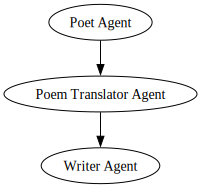

In [22]:
crew.plot()

In [27]:
crew.run()


RUNNING AGENT: <__main__.Agent object at 0x10abefd60>

En la danza del cosmos, un suspiro,
Somos polvo de estrellas, un destello fugaz,
Buscando sentido en el vasto vacío,
Tejiendo historias con hilos de paz.

Cada amanecer, un lienzo en blanco,
Cada decisión, un pincel en la mano,
Pintamos con amor, dolor y quebranto,
El cuadro de la vida, efímero y humano.

En las risas compartidas hallamos razón,
En la bondad sembrada, trascendencia,
En el abrazo cálido, nuestra canción,
Y en el servir a otros, nuestra esencia.

No es el destino, sino el viaje,
No la meta, sino el camino,
Lo que da a la vida su lenguaje,
Y al ser humano, su divino sino.

Así pues, vivamos con pasión y entereza,
Pues en cada instante yace la eternidad,
Y en la búsqueda misma de la belleza,
Encontramos nuestra propia verdad.

RUNNING AGENT: <__main__.Agent object at 0x10abf9fa0>

Nella danza del cosmo, un sospiro,
Siamo polvere di stelle, un lampo fugace,
Cercando senso nel vasto vuoto,
Tessendo storie con fili di pa